## 5. k-Nearest Neighbours model

<li> Train and tune the number of neighbours in k-Nearest Neighbours model for a one time-series from each cluster. </li> <li> Using found parameters, compute the forecast for a different time-series from the same cluster. </li>

In [69]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid

In [70]:
df = pd.read_pickle('demand_data_for_modelling')
df.head(5)

,meter_id,date,demand,hours,normalized_demand,demand-24h,normalized_demand-24h
0,1,2005-01-01 00:00:00,3304.0,0.0,0.330996,NaN,NaN
1,1,2005-01-01 01:00:00,3178.0,1.0,0.318373,NaN,NaN
2,1,2005-01-01 02:00:00,2981.0,2.0,0.298638,NaN,NaN
3,1,2005-01-01 03:00:00,2944.0,3.0,0.294931,NaN,NaN
4,1,2005-01-01 04:00:00,2934.0,4.0,0.293929,NaN,NaN


In [71]:
temperature = pd.read_pickle('temperature_for_modelling')
temperature.head(5)

,full_date,hourly_mean,normalized_temp
0,2005-01-01 00:00:00,44.535714,0.390571
1,2005-01-01 01:00:00,44.428571,0.389273
2,2005-01-01 02:00:00,43.535714,0.378460
3,2005-01-01 03:00:00,43.750000,0.381055
4,2005-01-01 04:00:00,43.321429,0.375865


In [72]:
humidity = pd.read_pickle('humidity_for_modelling')
humidity.head(5)

,full_date,hourly_mean,normalized_humidity
0,2005-01-01 00:00:00,87.535714,0.879677
1,2005-01-01 01:00:00,86.678571,0.869473
2,2005-01-01 02:00:00,86.964286,0.872874
3,2005-01-01 03:00:00,87.214286,0.875850
4,2005-01-01 04:00:00,87.357143,0.877551


Functions for modelling
--

Split the data into train, validation, and test sets:

In [73]:
def train_val_test_split(df, test_fraction, cols):
    train_fraction = 1-test_fraction
    val_fraction = train_fraction + test_fraction/2
    dates = df.groupby(df.date.dt.date).count().date 
    split_train = (int)(len(dates)*train_fraction)
    split_val = (int)(len(dates)*val_fraction)
    end_train_date = pd.to_datetime(dates.index[split_train])
    end_val_date = pd.to_datetime(dates.index[split_val])
    
    X_tr = df[df.date < end_train_date][cols].values
    y_tr = df[df.date < end_train_date]['normalized_demand'].values
                        
    X_val = df[(df.date >= end_train_date) & (df.date < end_val_date)][cols].values
    y_val = df[(df.date >= end_train_date) & (df.date < end_val_date)]['normalized_demand'].values
    
    X_te = df[df.date >= end_val_date][cols].values
    y_te = df[df.date >= end_val_date]['normalized_demand'].values
    
    print('Train set')
    print('---------')
    print('Features: {} Target: {}\n'.format(X_tr.shape,y_tr.shape))
    
    print('Validation set')
    print('---------')
    print('Features: {} Target: {}\n'.format(X_val.shape,y_val.shape))

    print('Test set')
    print('--------')    
    print('Features: {} Target: {}'.format(X_te.shape,y_te.shape))
    
    return (X_tr,X_val,X_te,y_tr,y_val,y_te)

Split the data into train and test sets:

In [74]:
def train_test_split(df, test_fraction, cols):
    train_fraction = 1-test_fraction
    dates = df.groupby(df.date.dt.date).count().date
    split = (int)(len(dates)*train_fraction)
    split_date = pd.to_datetime(dates.index[split])
    
    X_tr = df[df.date < split_date][cols].values
    y_tr = df[df.date < split_date]['normalized_demand'].values
    
    X_te = df[df.date >= split_date][cols].values
    y_te = df[df.date >= split_date]['normalized_demand'].values
    
    print('Train set')
    print('---------')
    print('Features: {} Target: {}\n'.format(X_tr.shape,y_tr.shape))

    print('Test set')
    print('--------')    
    print('Features: {} Target: {}'.format(X_te.shape,y_te.shape))
    
    return (X_tr,X_te,y_tr,y_te)

Fine tune a k-NN regressor:

In [75]:
def fine_tune_kNN(k_range,X_tr,X_val,y_tr,y_val):
    # Function to perform a grid search for the parameters used in k-NN model
    
    # Create k-NN regressor
    pipe = Pipeline([
        ('knn', KNeighborsRegressor(
            algorithm='brute', # Brute-force search
            n_jobs=-1 # As many parallel jobs as possible
        ))
    ])
    
    grid = ParameterGrid({
        'knn__n_neighbors': k_range, # k
        'knn__weights': ['uniform', 'distance'], # Weighting function
        'knn__p': [1, 2], # L1 and L2 distance metrics
    })
    
    # Print the number of combinations
    print('Number of combinations for grid search:', len(grid))
    
    # Save MAE computed on the validation set
    valid_mae = []
    
    # Enumerate combinations starting from 1
    for i, params_dict in enumerate(grid, 1):
        
        # Print progress
        print('Combination {}/{}'.format(
            i, len(grid) # Total number of combinations
        ))
        
        # Set parameters
        pipe.set_params(**params_dict)
        
        # Fit a k-NN regressor
        pipe.fit(X_tr, y_tr) 
        
        # Save MAE for the validation set
        y_pred_val = pipe.predict(X_val)
        params_dict['MAE'] = MAE(y_val, y_pred_val)
        
        # Save result
        valid_mae.append(params_dict)
    
    print('done')
    
    # Create DataFrame with validation MAE
    mae_df = pd.DataFrame(valid_mae)
    return mae_df

Fine tune number of neighbours:

In [76]:
def fine_tune_k(p,weights,k_range,X_tr,X_val,X_te,y_tr,y_val,y_te):
    # Function to refine k search
    
    pipe = Pipeline([
        ('knn', KNeighborsRegressor(
            algorithm='brute', 
            p=p, 
            weights=weights, 
            n_jobs=-1 
        ))
    ])
    
    # Refine the k grid
    grid = ParameterGrid({
        'knn__n_neighbors': k_range
    })
    
    mae = []
    
    for i, params_dict in enumerate(grid, 1):
        # Print progress
        print('Combination {}/{}'.format(
            i, len(grid) # Total number of combinations
        ))
        
        # Set parameters
        pipe.set_params(**params_dict)
        
        # Fit a k-NN regressor
        pipe.fit(X_tr, y_tr)
        
        # Save MAE for the validation set
        y_pred_val = pipe.predict(X_val)
        params_dict['MAE_val'] = MAE(y_val, y_pred_val)
        
        # Save MAE for the test set
        y_pred_te = pipe.predict(X_te)
        params_dict['MAE_te'] = MAE(y_te, y_pred_te)
        
        # Save result
        mae.append(params_dict)
        
    print('done')
    
    # Create DataFrame with validation MAE
    mae_df = pd.DataFrame(mae)
    return mae_df

Compute MAE:

In [77]:
def MAE(y,y_pred):    
    return(np.mean(np.abs(y-y_pred)))

Plot the results:

In [78]:
def plot_predictions(X_tr,X_te,y_tr,y_te,y_pred_tr,y_pred_te):
    
    font = {'fontname':'Arial', 'size':'14'}
    font_title = {'fontname':'Arial', 'size':'16'}

    plt.figure(figsize=(9,6))

    # True values
    plt.plot(X_tr[:,0],y_tr,label='train set',color='black')
    plt.plot(X_te[:,0],y_te,label='test set',color='grey')    

    # Predictions
    plt.plot(X_tr[:,0],y_pred_tr,label='predictions train',color='blue')
    plt.plot(X_te[:,0],y_pred_te,label='predictions test',color='red')    

    plt.xlabel('Date',**font)
    plt.ylabel('Electricity demand',**font)

    plt.legend()
    plt.show()

Save the results:

In [79]:
def save_result(meter_id,X_tr,X_te,y_pred_tr,y_pred_te):
    df1 = pd.DataFrame({"meter_id": [meter_id]*X_tr.shape[0], "date": X_tr[:,0], \
                        "type": ['training']*X_tr.shape[0], "pred_value": y_pred_tr})
    df2 = pd.DataFrame({"meter_id": [meter_id]*X_te.shape[0], "date": X_te[:,0], \
                        "type": ['test']*X_te.shape[0], "pred_value": y_pred_te})
    result = pd.concat([df1,df2], ignore_index=True)
    return result

Models for time-series from the clusters
--

In [80]:
dtw_clusters = pd.read_pickle('dtw_clusters')
dtw_clusters.sort_values(by='cluster')

,cluster
meter_id_1,
481,1
422,1
52,1
419,1
81,1
86,1
89,1
104,1
113,1


__Cluster 1__

Tune a k-NN model for a one time-series, meter 422, from the cluster 1.

In [81]:
meter_422 = df[df['meter_id']==422]

Ensure the same dates in demand and weather time-series:

In [82]:
temperature_422 = temperature[temperature.full_date.isin(meter_422.date)]
humidity_422 = humidity[humidity.full_date.isin(meter_422.date)]

In [83]:
meter_422 = meter_422[meter_422.date.isin(temperature_422.full_date)]
meter_422 = meter_422[meter_422.date.isin(humidity_422.full_date)]
meter_422 = meter_422.reset_index()

In [84]:
meter_422['normalized_temp'] = temperature_422.normalized_temp
meter_422['normalized_humid'] = humidity_422.normalized_humidity

In [85]:
meter_422.head(5)

,index,meter_id,date,demand,hours,normalized_demand,demand-24h,normalized_demand-24h,normalized_temp,normalized_humid
0,8347632,422,2005-01-01 00:00:00,12258.0,0.0,0.440665,NaN,NaN,0.390571,0.879677
1,8347633,422,2005-01-01 01:00:00,8016.0,1.0,0.240268,NaN,NaN,0.389273,0.869473
2,8347634,422,2005-01-01 02:00:00,7813.0,2.0,0.230678,NaN,NaN,0.378460,0.872874
3,8347635,422,2005-01-01 03:00:00,7527.0,3.0,0.217167,NaN,NaN,0.381055,0.875850
4,8347636,422,2005-01-01 04:00:00,7529.0,4.0,0.217262,NaN,NaN,0.375865,0.877551


Split the data into train, validation, and test sets to fine tune k-NN model:

In [86]:
X_tr_422,X_val_422,X_te_422,y_tr_422,y_val_422,y_te_422 = \
train_val_test_split(meter_422, 0.2, ['date','hours','normalized_temp','normalized_humid'])

Train set
---------
Features: (49050, 4) Target: (49050,)

Validation set
---------
Features: (6143, 4) Target: (6143,)

Test set
--------
Features: (6144, 4) Target: (6144,)


Fine tune a k-NN regressor (pass the features matrix without a 'date' column):

In [87]:
grid_search_422 = fine_tune_kNN([10,20,30],X_tr_422[:,1:],X_val_422[:,1:],y_tr_422,y_val_422) 

Number of combinations for grid search: 12
Combination 1/12
Combination 2/12
Combination 3/12
Combination 4/12
Combination 5/12
Combination 6/12
Combination 7/12
Combination 8/12
Combination 9/12
Combination 10/12
Combination 11/12
Combination 12/12
done


In [88]:
grid_search_422.sort_values(by='MAE',ascending=True)

,MAE,knn__n_neighbors,knn__p,knn__weights
8,0.124669,30,1,uniform
10,0.124669,30,2,uniform
9,0.124723,30,1,distance
11,0.124729,30,2,distance
4,0.138515,20,1,uniform
6,0.138515,20,2,uniform
5,0.138574,20,1,distance
7,0.138580,20,2,distance
1,0.178203,10,1,distance
3,0.178206,10,2,distance


In [89]:
k_search_422 = fine_tune_k(1,'uniform',[28,30,32,35,40],X_tr_422[:,1:],X_val_422[:,1:],X_te_422[:,1:],y_tr_422,y_val_422,y_te_422)

Combination 1/5
Combination 2/5
Combination 3/5
Combination 4/5
Combination 5/5
done


In [90]:
k_search_422.sort_values(by='MAE_te',ascending=True)

,MAE_te,MAE_val,knn__n_neighbors
1,0.127251,0.124669,30
0,0.128567,0.125601,28
2,0.128857,0.125808,32
3,0.139634,0.133946,35
4,0.150259,0.142477,40


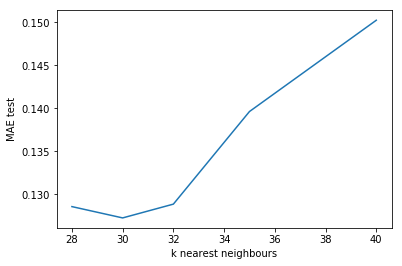

In [91]:
plt.plot(k_search_422.knn__n_neighbors,k_search_422.MAE_te)
plt.xlabel('k nearest neighbours')
plt.ylabel('MAE test')
plt.show()

More complex model based on more k neighbours leads to the increase of prediction error, signaling an overfitting.

Train regressor using the found parameters set and compute the forecast for a test time-series from the same cluster:

In [92]:
meter_481 = df[df['meter_id']==481]

In [93]:
temperature_481 = temperature[temperature.full_date.isin(meter_481.date)].reset_index()
humidity_481 = humidity[humidity.full_date.isin(meter_481.date)].reset_index()

In [94]:
meter_481 = meter_481[meter_481.date.isin(temperature_481.full_date)]
meter_481 = meter_481[meter_481.date.isin(humidity_481.full_date)]
meter_481 = meter_481.reset_index()

In [95]:
meter_481['normalized_temp'] = temperature_481.normalized_temp
meter_481['normalized_humid'] = humidity_481.normalized_humidity

In [96]:
meter_481.head()

,index,meter_id,date,demand,hours,normalized_demand,demand-24h,normalized_demand-24h,normalized_temp,normalized_humid
0,9432360,481,2009-04-16 00:00:00,0.0,0.0,0.000000,NaN,NaN,0.424740,0.740221
1,9432361,481,2009-04-16 01:00:00,0.0,1.0,0.000000,NaN,NaN,0.410900,0.750850
2,9432362,481,2009-04-16 02:00:00,8.0,2.0,0.000563,NaN,NaN,0.397491,0.763605
3,9432363,481,2009-04-16 03:00:00,7.0,3.0,0.000492,NaN,NaN,0.387543,0.764881
4,9432364,481,2009-04-16 04:00:00,8.0,4.0,0.000563,NaN,NaN,0.380623,0.773384


Split the data into training and test sets:

In [97]:
X_tr_481,X_te_481,y_tr_481,y_te_481 = train_test_split(meter_481, 0.2, ['date','hours','normalized_temp','normalized_humid'])

Train set
---------
Features: (19006, 4) Target: (19006,)

Test set
--------
Features: (4752, 4) Target: (4752,)


In [98]:
knn = KNeighborsRegressor(n_neighbors=30, p=1, weights='uniform')
knn.fit(X_tr_481[:,1:],y_tr_481)

# Compute predictions on train/test sets
y_pred_tr = knn.predict(X_tr_481[:,1:])
y_pred_te = knn.predict(X_te_481[:,1:])

# Compute a MAE
mae_tr = MAE(y_tr_481, y_pred_tr)
mae_te = MAE(y_te_481, y_pred_te)

print('Train set MAE')
print('---------')
print('MAE computed on the train set: ', np.round(mae_tr,2))

print('Test set MAE')
print('--------')    
print('MAE computed on the test set: ', np.round(mae_te, 2))

Train set MAE
---------
MAE computed on the train set:  0.1
Test set MAE
--------
MAE computed on the test set:  0.13


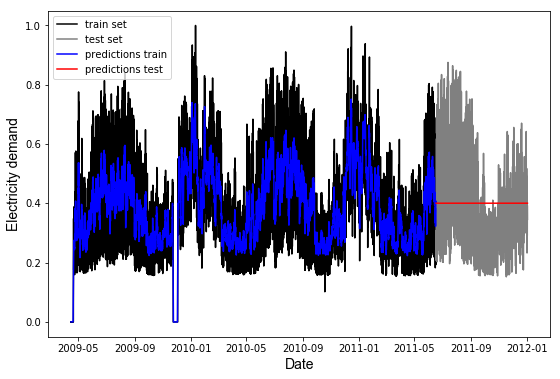

In [99]:
plot_predictions(X_tr_481,X_te_481,y_tr_481,y_te_481,y_pred_tr,y_pred_te)

Computed forecast represents a line because the range of "hours" values in the test set was never observed in the training range. To correct this behaviour, use the offset of demand as a feature.

Tune k-NN model for the meter 422 with a new set of features:

In [100]:
meter_422.dropna(inplace=True)

In [101]:
X_tr_422,X_val_422,X_te_422,y_tr_422,y_val_422,y_te_422 = \
train_val_test_split(meter_422, 0.2, ['date','normalized_demand-24h','normalized_temp','normalized_humid'])

Train set
---------
Features: (49050, 4) Target: (49050,)

Validation set
---------
Features: (6119, 4) Target: (6119,)

Test set
--------
Features: (6144, 4) Target: (6144,)


In [102]:
grid_search_422 = fine_tune_kNN([10,20,30],X_tr_422[:,1:],X_val_422[:,1:],y_tr_422,y_val_422) 

Number of combinations for grid search: 12
Combination 1/12
Combination 2/12
Combination 3/12
Combination 4/12
Combination 5/12
Combination 6/12
Combination 7/12
Combination 8/12
Combination 9/12
Combination 10/12
Combination 11/12
Combination 12/12
done


In [103]:
grid_search_422.sort_values(by='MAE',ascending=True)

,MAE,knn__n_neighbors,knn__p,knn__weights
8,0.050950,30,1,uniform
9,0.051084,30,1,distance
10,0.051106,30,2,uniform
11,0.051186,30,2,distance
6,0.051239,20,2,uniform
4,0.051450,20,1,uniform
7,0.051467,20,2,distance
5,0.051592,20,1,distance
0,0.052179,10,1,uniform
2,0.052241,10,2,uniform


In [104]:
k_search_422 = fine_tune_k(1,'uniform',[30,35,40,45,50,55],X_tr_422[:,1:],X_val_422[:,1:],X_te_422[:,1:],y_tr_422,y_val_422,y_te_422)

Combination 1/6
Combination 2/6
Combination 3/6
Combination 4/6
Combination 5/6
Combination 6/6
done


In [105]:
k_search_422.sort_values(by='MAE_te',ascending=True)

,MAE_te,MAE_val,knn__n_neighbors
5,0.046654,0.050932,55
4,0.046670,0.050956,50
3,0.046694,0.050956,45
2,0.046724,0.050961,40
1,0.046773,0.050953,35
0,0.046813,0.050950,30


To train the regressor and compute the forecast for meter 481, use k=40 because the decrease in MAE for the test data set is very small when k is increased above 40.

Compute the forecast for meter 481 with a new set of features:

In [106]:
meter_481.dropna(inplace=True)
X_tr_481,X_te_481,y_tr_481,y_te_481 = \
train_test_split(meter_481, 0.2, ['date','normalized_demand-24h','normalized_temp','normalized_humid'])

Train set
---------
Features: (18982, 4) Target: (18982,)

Test set
--------
Features: (4752, 4) Target: (4752,)


In [107]:
knn = KNeighborsRegressor(n_neighbors=40, p=1, weights='uniform') 
knn.fit(X_tr_481[:,1:],y_tr_481)

# Compute predictions on train/test sets
y_pred_tr = knn.predict(X_tr_481[:,1:])
y_pred_te = knn.predict(X_te_481[:,1:])

# Compute a MAE
mae_tr = MAE(y_tr_481, y_pred_tr)
mae_te = MAE(y_te_481, y_pred_te)

print('Train set MAE')
print('---------')
print('MAE computed on the train set: ', np.round(mae_tr,2))

print('Test set MAE')
print('--------')    
print('MAE computed on the test set: ', np.round(mae_te, 2))

Train set MAE
---------
MAE computed on the train set:  0.04
Test set MAE
--------
MAE computed on the test set:  0.04


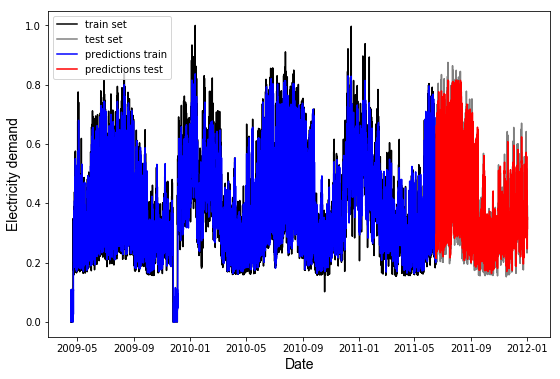

In [108]:
plot_predictions(X_tr_481,X_te_481,y_tr_481,y_te_481,y_pred_tr,y_pred_te)

Forecast results were improved when using a lag in the demand data.

Save the results:

In [109]:
pred_481 = save_result(481,X_tr_481,X_te_481,y_pred_tr,y_pred_te)

In [110]:
pred_481.to_pickle('kNN_meter481')

__Cluster 2__

Tune a k-NN model for a one time-series, meter 60, from the cluster 2.

In [111]:
meter_60 = df[df['meter_id']==60]

In [112]:
temperature_60 = temperature[temperature.full_date.isin(meter_60.date)]
humidity_60 = humidity[humidity.full_date.isin(meter_60.date)]

In [113]:
meter_60 = meter_60[meter_60.date.isin(temperature_60.full_date)]
meter_60 = meter_60[meter_60.date.isin(humidity_60.full_date)]
meter_60 = meter_60.reset_index()

In [114]:
meter_60['normalized_temp'] = temperature_60.normalized_temp
meter_60['normalized_humid'] = humidity_60.normalized_humidity

In [115]:
meter_60.head(5)

,index,meter_id,date,demand,hours,normalized_demand,demand-24h,normalized_demand-24h,normalized_temp,normalized_humid
0,1587432,60,2005-01-01 00:00:00,4379.0,0.0,0.078669,NaN,NaN,0.390571,0.879677
1,1587433,60,2005-01-01 01:00:00,5598.0,1.0,0.155943,NaN,NaN,0.389273,0.869473
2,1587434,60,2005-01-01 02:00:00,5502.0,2.0,0.149857,NaN,NaN,0.378460,0.872874
3,1587435,60,2005-01-01 03:00:00,5442.0,3.0,0.146054,NaN,NaN,0.381055,0.875850
4,1587436,60,2005-01-01 04:00:00,5562.0,4.0,0.153661,NaN,NaN,0.375865,0.877551


In [116]:
meter_60.dropna(inplace=True)

Use the lag in demand as an additional feature based on the observations from Cluster 1:

In [117]:
X_tr_60,X_val_60,X_te_60,y_tr_60,y_val_60,y_te_60 = \
train_val_test_split(meter_60, 0.2, ['date','normalized_demand-24h','normalized_temp','normalized_humid'])

Train set
---------
Features: (49050, 4) Target: (49050,)

Validation set
---------
Features: (6119, 4) Target: (6119,)

Test set
--------
Features: (6144, 4) Target: (6144,)


In [118]:
grid_search_60 = fine_tune_kNN([10,20,30],X_tr_60[:,1:],X_val_60[:,1:],y_tr_60,y_val_60) 

Number of combinations for grid search: 12
Combination 1/12
Combination 2/12
Combination 3/12
Combination 4/12
Combination 5/12
Combination 6/12
Combination 7/12
Combination 8/12
Combination 9/12
Combination 10/12
Combination 11/12
Combination 12/12
done


In [119]:
grid_search_60.sort_values(by='MAE',ascending=True)

,MAE,knn__n_neighbors,knn__p,knn__weights
10,0.059907,30,2,uniform
11,0.059963,30,2,distance
8,0.060007,30,1,uniform
9,0.060032,30,1,distance
6,0.060040,20,2,uniform
7,0.060187,20,2,distance
4,0.060204,20,1,uniform
5,0.060279,20,1,distance
0,0.060969,10,1,uniform
2,0.061012,10,2,uniform


In [120]:
k_search_60 = \
fine_tune_k(2,'uniform',[28,30,32,35,40],X_tr_60[:,1:],X_val_60[:,1:],X_te_60[:,1:],y_tr_60,y_val_60,y_te_60)

Combination 1/5
Combination 2/5
Combination 3/5
Combination 4/5
Combination 5/5
done


In [121]:
k_search_60.sort_values(by='MAE_te',ascending=True)

,MAE_te,MAE_val,knn__n_neighbors
3,0.053639,0.059900,35
1,0.053641,0.059907,30
0,0.053663,0.059917,28
4,0.053664,0.059883,40
2,0.053671,0.059887,32


Using found parameters, compute the forecast for the meter 10:

In [122]:
meter_10 = df[df['meter_id']==10]
temperature_10 = temperature[temperature.full_date.isin(meter_10.date)].reset_index()
humidity_10 = humidity[humidity.full_date.isin(meter_10.date)].reset_index()
meter_10 = meter_10[meter_10.date.isin(temperature_10.full_date)]
meter_10 = meter_10[meter_10.date.isin(humidity_10.full_date)]
meter_10 = meter_10.reset_index()
meter_10['normalized_temp'] = temperature_10.normalized_temp
meter_10['normalized_humid'] = humidity_10.normalized_humidity
meter_10.head(5)

,index,meter_id,date,demand,hours,normalized_demand,demand-24h,normalized_demand-24h,normalized_temp,normalized_humid
0,483240,10,2005-01-01 00:00:00,2027.0,0.0,0.117804,NaN,NaN,0.390571,0.879677
1,483241,10,2005-01-01 01:00:00,3072.0,1.0,0.229211,NaN,NaN,0.389273,0.869473
2,483242,10,2005-01-01 02:00:00,2870.0,2.0,0.207676,NaN,NaN,0.378460,0.872874
3,483243,10,2005-01-01 03:00:00,2851.0,3.0,0.205650,NaN,NaN,0.381055,0.875850
4,483244,10,2005-01-01 04:00:00,2900.0,4.0,0.210874,NaN,NaN,0.375865,0.877551


In [123]:
meter_10.dropna(inplace=True)

In [124]:
X_tr_10,X_te_10,y_tr_10,y_te_10 = \
train_test_split(meter_10, 0.2, ['date','normalized_demand-24h','normalized_temp','normalized_humid'])

Train set
---------
Features: (49050, 4) Target: (49050,)

Test set
--------
Features: (12263, 4) Target: (12263,)


In [125]:
knn = KNeighborsRegressor(n_neighbors=40, p=2, weights='uniform') 
knn.fit(X_tr_10[:,1:],y_tr_10)

# Compute predictions on train/test sets
y_pred_tr = knn.predict(X_tr_10[:,1:])
y_pred_te = knn.predict(X_te_10[:,1:])

# Compute a MAE
mae_tr = MAE(y_tr_10, y_pred_tr)
mae_te = MAE(y_te_10, y_pred_te)

print('Train set MAE')
print('---------')
print('MAE computed on the train set: ', np.round(mae_tr,2))

print('Test set MAE')
print('--------')    
print('MAE computed on the test set: ', np.round(mae_te, 2))

Train set MAE
---------
MAE computed on the train set:  0.04
Test set MAE
--------
MAE computed on the test set:  0.04


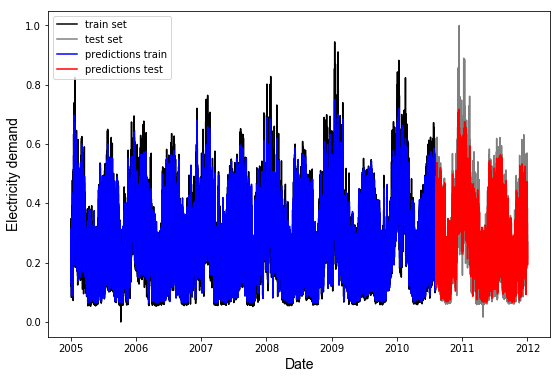

In [126]:
plot_predictions(X_tr_10,X_te_10,y_tr_10,y_te_10,y_pred_tr,y_pred_te)

In [127]:
pred_10 = save_result(10,X_tr_10,X_te_10,y_pred_tr,y_pred_te)

In [128]:
pred_10.to_pickle('kNN_meter10')

__Cluster 3__

Tune a k-NN model for a one time-series, meter 412, from the cluster 3.

In [129]:
meter_412 = df[df['meter_id']==412]
temperature_412 = temperature[temperature.full_date.isin(meter_412.date)]
humidity_412 = humidity[humidity.full_date.isin(meter_412.date)]
meter_412 = meter_412[meter_412.date.isin(temperature_412.full_date)]
meter_412 = meter_412[meter_412.date.isin(humidity_412.full_date)]
meter_412 = meter_412.reset_index()
meter_412['normalized_temp'] = temperature_412.normalized_temp
meter_412['normalized_humid'] = humidity_412.normalized_humidity
meter_412.head()

,index,meter_id,date,demand,hours,normalized_demand,demand-24h,normalized_demand-24h,normalized_temp,normalized_humid
0,7979568,412,2005-01-01 00:00:00,714.5,0.0,0.324478,NaN,NaN,0.390571,0.879677
1,7979569,412,2005-01-01 01:00:00,8.0,1.0,0.003633,NaN,NaN,0.389273,0.869473
2,7979570,412,2005-01-01 02:00:00,8.0,2.0,0.003633,NaN,NaN,0.378460,0.872874
3,7979571,412,2005-01-01 03:00:00,8.0,3.0,0.003633,NaN,NaN,0.381055,0.875850
4,7979572,412,2005-01-01 04:00:00,8.0,4.0,0.003633,NaN,NaN,0.375865,0.877551


In [130]:
meter_412.dropna(inplace=True)

In [131]:
X_tr_412,X_val_412,X_te_412,y_tr_412,y_val_412,y_te_412 = \
train_val_test_split(meter_412, 0.2, ['date','normalized_demand-24h','normalized_temp','normalized_humid'])

Train set
---------
Features: (49050, 4) Target: (49050,)

Validation set
---------
Features: (6119, 4) Target: (6119,)

Test set
--------
Features: (6144, 4) Target: (6144,)


In [132]:
grid_search_412 = fine_tune_kNN([10,20,30],X_tr_412[:,1:],X_val_412[:,1:],y_tr_412,y_val_412) 

Number of combinations for grid search: 12
Combination 1/12
Combination 2/12
Combination 3/12
Combination 4/12
Combination 5/12
Combination 6/12
Combination 7/12
Combination 8/12
Combination 9/12
Combination 10/12
Combination 11/12
Combination 12/12
done


In [133]:
grid_search_412.sort_values(by='MAE',ascending=True)

,MAE,knn__n_neighbors,knn__p,knn__weights
11,0.029414,30,2,distance
9,0.029448,30,1,distance
10,0.029463,30,2,uniform
8,0.029474,30,1,uniform
6,0.029571,20,2,uniform
7,0.029605,20,2,distance
4,0.029612,20,1,uniform
5,0.029636,20,1,distance
0,0.030108,10,1,uniform
2,0.030219,10,2,uniform


In [134]:
k_search_412 = \
fine_tune_k(1,'distance',[28,30,32,35,40],X_tr_412[:,1:],X_val_412[:,1:],X_te_412[:,1:],y_tr_412,y_val_412,y_te_412)

Combination 1/5
Combination 2/5
Combination 3/5
Combination 4/5
Combination 5/5
done


In [135]:
k_search_412.sort_values(by='MAE_te',ascending=True)

,MAE_te,MAE_val,knn__n_neighbors
1,0.020852,0.029448,30
2,0.020858,0.029424,32
3,0.020868,0.029392,35
0,0.020871,0.029474,28
4,0.020908,0.029360,40


Using found parameters, compute the forecast for the meter 453:

In [136]:
meter_453 = df[df['meter_id']==453]
temperature_453 = temperature[temperature.full_date.isin(meter_453.date)].reset_index()
humidity_453 = humidity[humidity.full_date.isin(meter_453.date)].reset_index()
meter_453 = meter_453[meter_453.date.isin(temperature_453.full_date)]
meter_453 = meter_453[meter_453.date.isin(humidity_453.full_date)]
meter_453 = meter_453.reset_index()
meter_453['normalized_temp'] = temperature_453.normalized_temp
meter_453['normalized_humid'] = humidity_453.normalized_humidity
meter_453.head(5)

,index,meter_id,date,demand,hours,normalized_demand,demand-24h,normalized_demand-24h,normalized_temp,normalized_humid
0,8980008,453,2005-06-01 00:00:00,1898.5,0.0,0.392983,NaN,NaN,0.608131,0.737245
1,8980009,453,2005-06-01 01:00:00,0.0,1.0,0.000000,NaN,NaN,0.602941,0.736395
2,8980010,453,2005-06-01 02:00:00,0.0,2.0,0.000000,NaN,NaN,0.595156,0.760204
3,8980011,453,2005-06-01 03:00:00,0.0,3.0,0.000000,NaN,NaN,0.586505,0.781037
4,8980012,453,2005-06-01 04:00:00,0.0,4.0,0.000000,NaN,NaN,0.581315,0.802721


In [137]:
meter_453.dropna(inplace=True)

In [138]:
X_tr_453,X_te_453,y_tr_453,y_te_453 = \
train_test_split(meter_453, 0.2, ['date','normalized_demand-24h','normalized_temp','normalized_humid'])

Train set
---------
Features: (46147, 4) Target: (46147,)

Test set
--------
Features: (11543, 4) Target: (11543,)


In [140]:
knn = KNeighborsRegressor(n_neighbors=30, p=1, weights='distance') 
knn.fit(X_tr_453[:,1:],y_tr_453)

# Compute predictions on train/test sets
y_pred_tr = knn.predict(X_tr_453[:,1:])
y_pred_te = knn.predict(X_te_453[:,1:])

# Compute a MAE
mae_tr = MAE(y_tr_453, y_pred_tr)
mae_te = MAE(y_te_453, y_pred_te)

print('Train set MAE')
print('---------')
print('MAE computed on the train set: ', np.round(mae_tr,2))

print('Test set MAE')
print('--------')    
print('MAE computed on the test set: ', np.round(mae_te, 2))

Train set MAE
---------
MAE computed on the train set:  0.0
Test set MAE
--------
MAE computed on the test set:  0.04


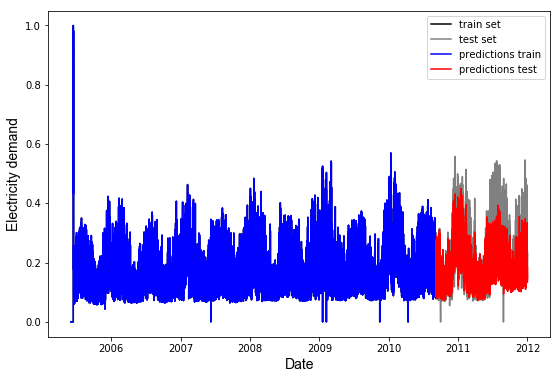

In [141]:
plot_predictions(X_tr_453,X_te_453,y_tr_453,y_te_453,y_pred_tr,y_pred_te)

In [142]:
pred_453 = save_result(453,X_tr_453,X_te_453,y_pred_tr,y_pred_te)

In [145]:
pred_453.to_pickle('kNN_meter453')